<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Set" data-toc-modified-id="Data-Set-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Set</a></span><ul class="toc-item"><li><span><a href="#Air-Quality-Data-Set" data-toc-modified-id="Air-Quality-Data-Set-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Air Quality Data Set</a></span><ul class="toc-item"><li><span><a href="#Abstract:" data-toc-modified-id="Abstract:-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Abstract:</a></span></li><li><span><a href="#Source:" data-toc-modified-id="Source:-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Source:</a></span></li><li><span><a href="#Data-Set-Information:" data-toc-modified-id="Data-Set-Information:-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Data Set Information:</a></span></li><li><span><a href="#Attribute-Information:" data-toc-modified-id="Attribute-Information:-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Attribute Information:</a></span></li></ul></li></ul></li><li><span><a href="#Preprocessing-and-Analysis" data-toc-modified-id="Preprocessing-and-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing and Analysis</a></span><ul class="toc-item"><li><span><a href="#Plotting" data-toc-modified-id="Plotting-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Split" data-toc-modified-id="Split-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split</a></span></li></ul></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pipeline</a></span><ul class="toc-item"><li><span><a href="#Models" data-toc-modified-id="Models-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Models</a></span></li><li><span><a href="#CV" data-toc-modified-id="CV-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CV</a></span><ul class="toc-item"><li><span><a href="#nested-CV" data-toc-modified-id="nested-CV-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>nested CV</a></span></li></ul></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Metrics</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os

import matplotlib.pyplot as plt

import pandas as pd
import pandas_profiling
import numpy as np
from scipy import stats

from sklearn.model_selection import cross_validate, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

# Data Set

## Air Quality Data Set 

### Abstract: 

Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer.

### Source:

Saverio De Vito (saverio.devito '@' enea.it), ENEA - National Agency for New Technologies, Energy and Sustainable Economic Development

### Data Set Information:

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. 

This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded. 

### Attribute Information:

0. Date	(DD/MM/YYYY) 
1. Time	(HH.MM.SS) 
2. True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
5. **True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)**
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
7. True hourly averaged NOx concentration in ppb (reference analyzer) 
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
12. Temperature in Â°C	
13. Relative Humidity (%) 
14. AH Absolute Humidity 

In [4]:
TARGET_COLUMN = 'C6H6(GT)'

In [5]:
data = pd.read_csv(os.path.join('data', 'AirQualityUCI.csv'), delimiter=';', decimal=",")
data = data[data.columns[:-2]]
data.head(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


# Preprocessing and Analysis

In [6]:
data.shape

(9471, 15)

In [7]:
data = data.dropna(how='all') # Drop the rows where all elements are missing.

In [8]:
data.shape

(9357, 15)

In [9]:
data = data.drop_duplicates()

In [10]:
data.shape

(9357, 15)

In [11]:
data.dtypes

Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

In [12]:
data['date_time'] =  pd.to_datetime(data['Date'] + ' ' +  data['Time'], format='%d/%m/%Y %H.%M.%S')
data = data.drop(columns=['Date', 'Time'])

In [13]:
data.dtypes

CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
date_time        datetime64[ns]
dtype: object

In [14]:
data = data.replace(-200, np.nan)
data.isna().sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
date_time           0
dtype: int64

Выделим только те запис, где таргет наблюдается, и затем изобразим данные на грфике, чтобы посмотреть на динамику факторов.

In [15]:
def filter_unubserved(data, column_name):
    unubserved_filter = data[column_name].isna()
    unubserved_data = data.loc[unubserved_filter]
    ubserved_data = data.loc[~unubserved_filter]
    return unubserved_data, ubserved_data


def plot_column(data, column_name):
    _, to_print_data = filter_unubserved(data, column_name)
    plt.plot(to_print_data['date_time'], to_print_data[column_name])

In [16]:
unubserved_data, data = filter_unubserved(data, TARGET_COLUMN)

In [17]:
unubserved_data.shape,  data.shape

((366, 14), (8991, 14))

## Plotting

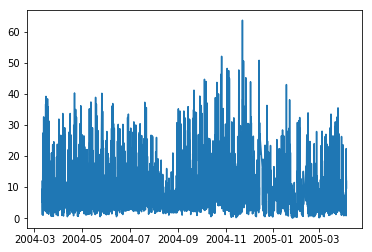

In [18]:
plot_column(data, 'C6H6(GT)')

В таргете не наблюдается ярко выраженного тренда, что говорит о том, что в процессе кроссвалидации можно "перемешивать" данные (это позволяет также и природа данных). Однако необходимо ещё проверить это свойство у остальных компонент.

> Также не преставляется возможным выделить полезную информацию из временной колонки. Следовательно она будет полностью (немодифицирована в фичу) исключена из списка факторов.

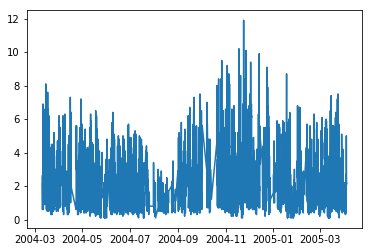

In [19]:
plot_column(data, 'CO(GT)')

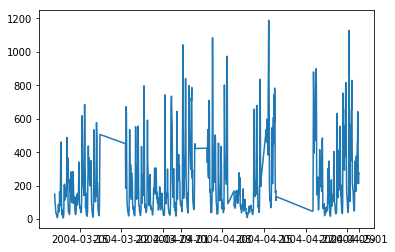

In [20]:
plot_column(data, 'NMHC(GT)')

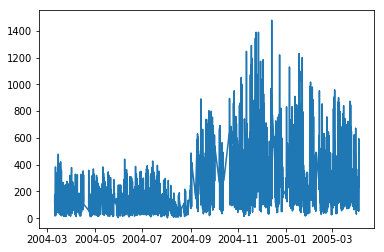

In [21]:
plot_column(data, 'NOx(GT)')

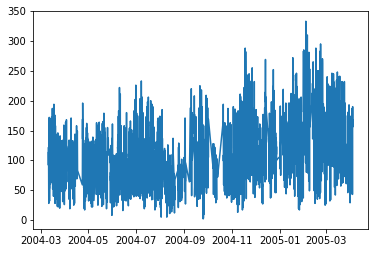

In [22]:
plot_column(data, 'NO2(GT)')

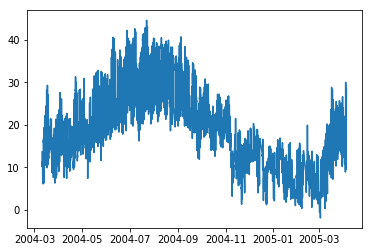

In [23]:
plot_column(data, 'T')

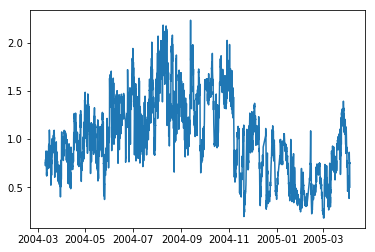

In [24]:
plot_column(data, 'AH')

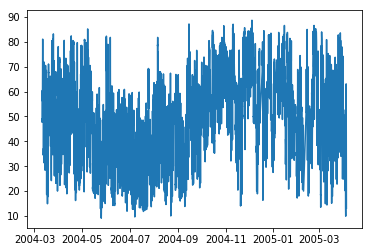

In [25]:
plot_column(data, 'RH')

Характер изменения во времени многих компонент ```('CO(GT)', 'NMHC(GT)', 'NO2(GT)')``` совпадает с таргетом, однако есть и те ```'NOx(GT)', 'AH', 'RH', 'T'```, рассматривая которые нельзя принебречь такой компонентой как время. В данном случае необходимо "наращивать" train. Это нужно учитывать при выборе параметров кросс-валидации. 

In [26]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7344.000000,8991.000000,887.000000,8991.000000,8991.000000,7396.000000,8991.000000,7393.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.129711,1099.833166,218.607666,10.083105,939.153376,242.189292,835.493605,112.145137,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.436472,217.080037,206.615130,7.449820,266.831429,206.312007,256.817320,47.629141,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,66.000000,4.400000,734.500000,97.000000,658.000000,77.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,145.000000,8.200000,909.000000,178.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.800000,1231.000000,297.000000,14.000000,1116.000000,321.000000,969.500000,140.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [27]:
num_data = data.drop(columns=['date_time']).drop_duplicates()
corr_matr = num_data.corr()
corr_matr

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.879288,0.889596,0.931078,0.915514,0.786401,-0.703446,0.673840,0.630703,0.854182,0.022109,0.048890,0.048556
PT08.S1(CO),0.879288,1.000000,0.790670,0.883795,0.892964,0.713654,-0.771938,0.641529,0.682881,0.899324,0.048627,0.114606,0.135324
NMHC(GT),0.889596,0.790670,1.000000,0.902559,0.877696,0.815522,-0.771135,0.732864,0.853267,0.766723,0.391587,-0.191454,0.269738
C6H6(GT),0.931078,0.883795,0.902559,1.000000,0.981950,0.718839,-0.735744,0.614474,0.765731,0.865689,0.198956,-0.061681,0.167972
PT08.S2(NMHC),0.915514,0.892964,0.877696,0.981950,1.000000,0.704435,-0.796703,0.646245,0.777254,0.880578,0.241373,-0.090380,0.186933
NOx(GT),0.786401,0.713654,0.815522,0.718839,0.704435,1.000000,-0.655707,0.758083,0.233731,0.787046,-0.269683,0.221032,-0.149323
PT08.S3(NOx),-0.703446,-0.771938,-0.771135,-0.735744,-0.796703,-0.655707,1.000000,-0.652083,-0.538468,-0.796569,-0.145112,-0.056740,-0.232017
NO2(GT),0.673840,0.641529,0.732864,0.614474,0.646245,0.758083,-0.652083,1.000000,0.157360,0.708128,-0.186533,-0.091759,-0.335022
PT08.S4(NO2),0.630703,0.682881,0.853267,0.765731,0.777254,0.233731,-0.538468,0.157360,1.000000,0.591144,0.561270,-0.032188,0.629641
PT08.S5(O3),0.854182,0.899324,0.766723,0.865689,0.880578,0.787046,-0.796569,0.708128,0.591144,1.000000,-0.027172,0.124956,0.070751


In [28]:
pandas_profiling.ProfileReport(num_data)

Number of variables,14
Number of observations,8991
Total Missing (%),10.3%
Total size in memory,983.5 KiB
Average record size in memory,112.0 B
Numeric,12
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,2


В признаках обнаружены пропущенные значения. Фактор ```NMHC(GT)``` содержит 90% пропущеных значений, поэтому его необходимо исключить из анализа. В случае остальных факторов необходимо будет избавиться от этих значений (заменив их, например, одной из оценок цетральной изменчивости с помощью [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)). SimpleImputer будет добавлен в Pipeline, а для продолжения первичной оценки данных, исключим ненаблюдаемые значения из датафрэйма

In [29]:
num_data = num_data.dropna()
pandas_profiling.ProfileReport(num_data)

Number of variables,14
Number of observations,827
Total Missing (%),0.0%
Total size in memory,90.5 KiB
Average record size in memory,112.1 B
Numeric,8
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,6


Многие признаки имеют высокую корреляцию друг с другом, что плохо скажется на оценках регрессии. Например, в случае полиномиальной модели и метода наименьших квадратов, линейная зависимость признаков скажется на решении СЛАУ, породив бесконечное множество решений. Таким образом, необходимо будет либо сокращать количество факторов либо применять механизмы регуляризации.

Многие элементы, используемые в целевой функции алгоритмов обучения (например, SVM или  L1/L2 **регуляризация** линейных моделей), предполагают, что все объекты центрированы вокруг нуля и имеют дисперсию того же порядка. 

Таким образом, необходимо будет стандартизовать величины, с которыми работаем. Однако если в данных содержится много выбросов, то центрирование с использованием оценок математического ожидания и дисперсии может работать не так хорошо, как ожидается. Поэтому определим процент выбросов в каждом факторе.

In [30]:
def get_outlier_precetage(col):
    new_shape = num_data[col].loc[np.abs(stats.zscore(num_data[col])) < 3].shape[0]
    old_shape = num_data[col].shape[0]
    return "{} %".format(round(100 * (1 - (new_shape / old_shape)), 2))

pd.Series({col: get_outlier_precetage(col) for col in num_data.columns})

CO(GT)           1.21 %
PT08.S1(CO)       0.6 %
NMHC(GT)         1.09 %
C6H6(GT)         1.09 %
PT08.S2(NMHC)     0.0 %
NOx(GT)          0.73 %
PT08.S3(NOx)     0.97 %
NO2(GT)          0.12 %
PT08.S4(NO2)      0.6 %
PT08.S5(O3)      0.24 %
T                 0.0 %
RH                0.0 %
AH               0.73 %
dtype: object

Выбросы есть, но их не много, поэтому можно попробовать [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler), а затем поэксперементирвоать с [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler).

## Split

Разделим данные на "фичи" и "таргет", в соответствии с требованиями интерфейса sklearn.

In [31]:
_data = data.drop(columns=['date_time'])
X = _data.drop(columns=[TARGET_COLUMN])
y = _data[[TARGET_COLUMN]]

# Pipeline

## Models

In [32]:
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
standart_scaler = StandardScaler()
robust_scaler = RobustScaler()
polynomial_features = PolynomialFeatures(2, interaction_only=True, include_bias=False)
linear_regression = LinearRegression()
ridge = Ridge()
lasso = Lasso()

svr = LinearSVR(random_state=0, tol=1e-3, max_iter=2000)
random_forest_regressor = RandomForestRegressor(n_estimators=100, max_features ='sqrt')

Рассмотрим несколько регрессионных моделей, а лучшую определим в процессе кросс валидации.

## CV

In [33]:
# 
model = Pipeline([
    ('imputer', simple_imputer), 
    ('scaler', standart_scaler), 
    ('polynomial_features', polynomial_features), 
    ('regression', linear_regression)
])

scoring = ['r2', 'neg_mean_squared_error']

parameters = {
    'scaler': [standart_scaler, robust_scaler],
    'regression': [linear_regression, ridge, lasso, svr, random_forest_regressor],
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    'polynomial_features__degree': [1, 2, 3] # 1 to check are polynomial features really needed.
}

model = GridSearchCV(model, parameters, scoring=scoring, cv=TimeSeriesSplit(n_splits=5), refit=scoring[0], verbose=1)

В процессе кросс валидации определим оптимальную регрессионную модель, оптимальный scaler, стратегию по обработке ненаблюдаемых значений и оптимальный парамитр глубины для процедуры построения полиномиальных фичей.

In [34]:
model.fit(X, y.values.ravel())

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 11.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomial_features', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)), ('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'scaler': [StandardScaler(copy=True, with_mean=True, with_std=True), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'regression': [LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), Ridge(alpha=... 'imputer__strategy': ['mean', 'median', 'most_frequent'], 'polynomial_features__degree': [1, 2, 

In [35]:
model.best_score_

0.9993384774102251

In [36]:
model.best_estimator_

Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomial_features', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)), ('regression', LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=2000,
     random_state=0, tol=0.001, verbose=0))])

Оптимальной оказалась пара: стандартный скелер и LinearSVR. Решение принималось по метрике r^2. Рассмотрим динамику ещё одной метрики (среднеквадратичную ошибку) в зависимости от выбранной модели

### Nested CV

Если в процессе кросс валидации одно разбиение используется и для выбора оптимальной модели и для оценки качества модели, то в процессе выбора оптимальной модели тестовый дата сет, по факту "переобучается", так как на его основе выбирается оптимальная модель. Таким образом, он не годится, для оценки качества модели.

Поэтому построи оценки, добавив ещё один уровень проверки и сравним, получившиеся результаты.

In [37]:
cross_val_score(model, X, y.values.ravel(), cv=TimeSeriesSplit(n_splits=5))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  5.1min finished


Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  7.5min finished


Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  9.4min finished


array([0.99931823, 0.99822106, 0.99961246, 0.99941661, 0.99936976])

____

## Metrics

In [38]:
results = model.cv_results_

In [39]:
def index_rename(sub_model):
    for sub_model_name in ['LinearRegression', 'Ridge', 'Lasso', 'LinearSVR', 'RandomForestRegressor']:
        if str(sub_model).startswith(sub_model_name):
            return sub_model_name

models = [index_rename(sub_model) for sub_model in results['param_regression']]

In [40]:
scores = pd.DataFrame(data={
    'models': models,
    'mean_test_r2': results['mean_test_r2'], 
    'mean_test_neg_mean_squared_error': results['mean_test_neg_mean_squared_error']})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000185430EDD30>,
      dtype=object)

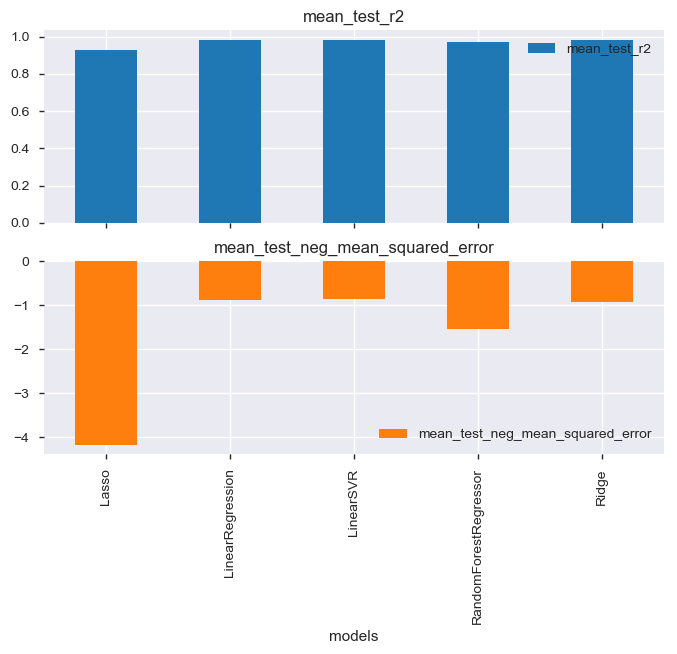

In [41]:
scores = scores.groupby('models').agg('mean')
scores.plot.bar(subplots=True)

Исключим линейную регрессионную модель с L1 регуляризацией, для того чтобы визульно сранвить качество остальных моделей. Для следующей "худшей модели поступим аналогично". 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001854259DA90>,
      dtype=object)

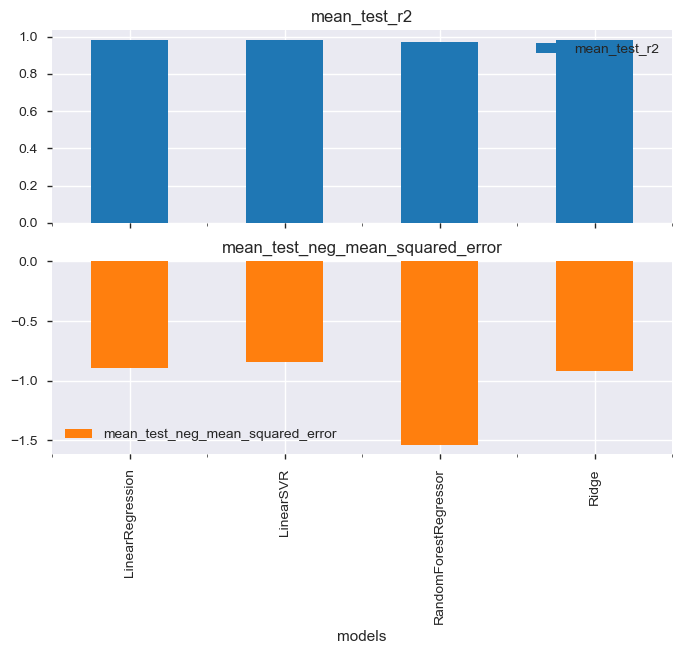

In [42]:
scores = scores.drop('Lasso')
scores.plot.bar(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001853FF6EF28>,
      dtype=object)

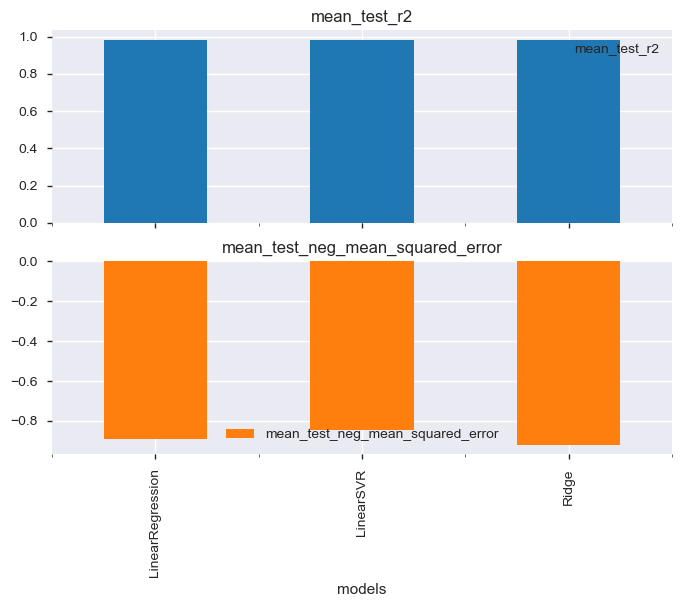

In [43]:
scores = scores.drop('RandomForestRegressor')
scores.plot.bar(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000185430F3128>,
      dtype=object)

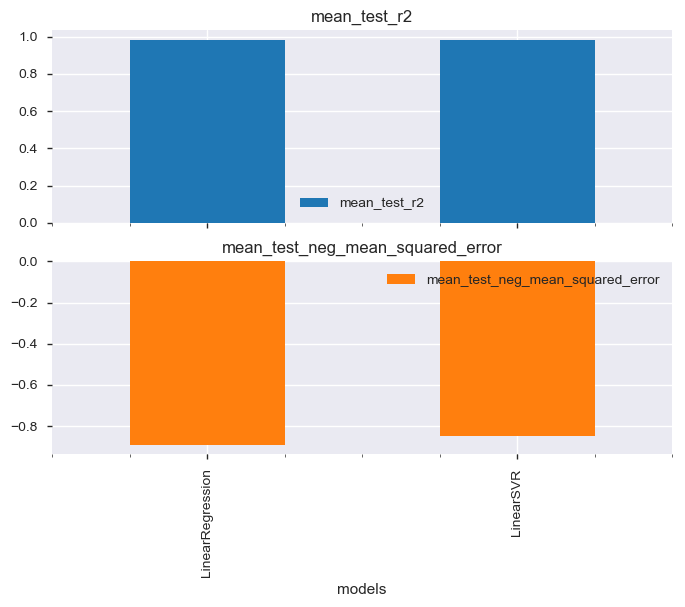

In [44]:
scores = scores.drop('Ridge')
scores.plot.bar(subplots=True)

В результате экспериментов лучшими являются простая линейная регерессия и модель на основе опорных векторов, однако в данном эксперименте вторая модель показала лучшее качество по обеим метрикам.

## Feature importance

In [64]:
regresion_model = model.best_estimator_.steps[3][1]
regresion_model.get_params()

{'C': 1.0,
 'dual': True,
 'epsilon': 0.0,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'loss': 'epsilon_insensitive',
 'max_iter': 2000,
 'random_state': 0,
 'tol': 0.001,
 'verbose': 0}

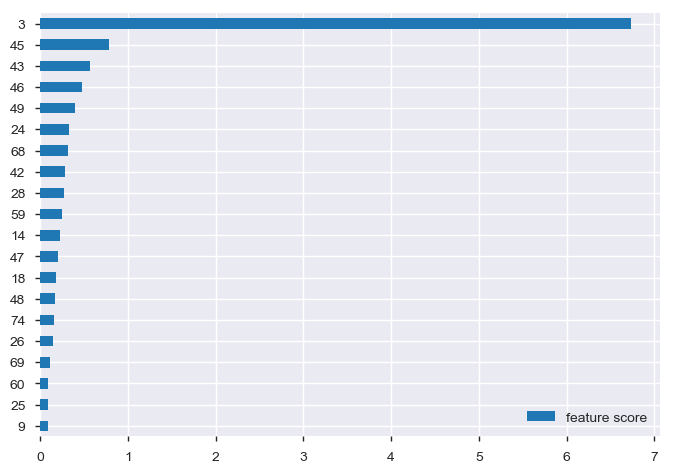

In [109]:
coef = np.abs(regresion_model.coef_)
features = pd.DataFrame(coef, columns=['feature score']).sort_values('feature score')
features.tail(20).plot.barh()